<a href="https://colab.research.google.com/github/thor4/neuralnets/blob/master/projects/1-CNN/step4-train_iterations-van_gabor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run Train Iterations
--- 


Here we will re-train existing models in preparation for iterative tilt/contrast testing.

## 0: Check hardware & load libraries

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar  2 15:43:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from google.colab import files

## 1: Load & prepare datasets 
### Load and prepare the data
The dataset is comprised of 21,000 total Gabors in two classes representing tilts from 45 degrees in the clockwise direction and tilts in the counterclockwise direction. The Gabors were generated in MATLAB using gen_gabor-range_random.m which used a range of 3 contrasts with random tilts from [0.05, 2]. 
- `tilts = rand[0.05,2]; # measured in degrees`
- `contrasts = [.3, .45, 1];  # measured in percent`  

3500 Gabors were generated for each of the 3 contrasts for each of the 2 classes (3500 x 3 x 2 = 21,000 total images). The dataset is divided into 13,998 training images, 5,598 validation images, and 1,404 testing images. 

We will download a zip file from OSF then extract its contents and change into the newly created directory: `content/model_training-range_con_rand_tilt/`

In [4]:
# @title Download data to train the model

import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping vanilla Gabor training dataset...")
name = 'model_training-range_con_rand_tilt_0_05-2'
fname = f"{name}.zip"
url = f"https://osf.io/rhe6k/download" #osf share link
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content) #download file

with ZipFile(fname, 'r') as zfile:
  zfile.extractall(f"./{name}") #extract contents

if os.path.exists(fname):
  os.remove(fname) #delete zip file
else:
  print(f"The file {fname} does not exist")

os.chdir(name) #move into extracted folder root
print("Download completed.")

Start downloading and unzipping vanilla Gabor training dataset...
Download completed.


Download the test datasets from OSF and extract the contents into the newly created directory: `content/datasets/`

After downloading, we can load the data into datasets structured for training a neural network. The batch size will be set at 32 and image size at 160 x 160. 

In [5]:
def load_data():
    curr_dir = os.getcwd() 
    train_dir = os.path.join(curr_dir, 'train_range_rand')
    validation_dir = os.path.join(curr_dir, 'valid_range_rand')
    test_dir = os.path.join(curr_dir, 'test_range_rand')
    BATCH_SIZE = 32 
    IMG_SIZE = (160, 160)
    train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             color_mode='grayscale') 
    validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  color_mode='grayscale') 
    test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  color_mode='grayscale') 
    class_names = train_dataset.class_names #assign clockwise (clock) & counterclockwise (cclock) classes
    return BATCH_SIZE,IMG_SIZE,train_dataset,validation_dataset,test_dataset,class_names

BATCH_SIZE, IMG_SIZE, train_dataset, validation_dataset, test_dataset, class_names = load_data()

Found 13998 files belonging to 2 classes.
Found 5598 files belonging to 2 classes.
Found 1404 files belonging to 2 classes.


Confirm the images are only 1 channel (grayscale)

In [6]:
train_dataset.element_spec

(TensorSpec(shape=(None, 160, 160, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

### Verify the data
To verify that the training datasets look correct, let's plot the first 9 images from the training set and display the class name above each image:

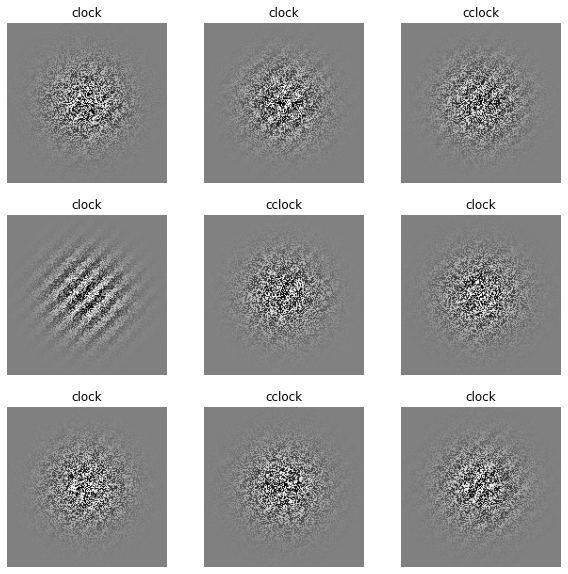

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): #load first iteration batch from training dataset
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1) #setup axis on a 3x3 grid
    #plt.imshow(images[i].numpy().astype("uint8"),cmap='gray') #plot each image
    plt.imshow(images[i].numpy().squeeze(axis=2).astype("uint8"),cmap='gray') #plot each image
    plt.title(class_names[labels[i]]) #output associated label for chosen image
    plt.axis("off")
    


### Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general we should seek to make our input values small. We will standardize values to be in the `[0, 1]` range by using the `tf.keras.layers.experimental.preprocessing.Rescaling` layer.

In [8]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y)) #apply normalization to dataset
image_batch, labels_batch = next(iter(normalized_ds)) #extract one batch from the norm'd dataset
first_image = image_batch[0] #view first image from the batch
image_batch2, labels_batch2 = next(iter(train_dataset)) #extract one batch from the original dataset
first_image2 = image_batch2[0] #view first image from the batch
print(f"before normalization:",np.min(first_image2),np.max(first_image2),"\n",
      f"after normalization:",np.min(first_image),np.max(first_image)) #notice the pixels values are now in `[0,1]`.

before normalization: 0.17871094 252.99121 
 after normalization: 0.0007008272 0.9996324


Now that we are convinced the normalization works, we will include it as the first layer inside our model definition below to simplify deployment.

### Setup buffered prefetching
We can configure the dataset for performance using buffered prefetching to load images from disk without having I/O become blocking

In [9]:
def prefetch(train_dataset, validation_dataset, test_dataset):
    AUTOTUNE = tf.data.AUTOTUNE #prompts the tf.data runtime to tune the value dynamically at runtime
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    return train_dataset,validation_dataset,test_dataset,AUTOTUNE

train_dataset, validation_dataset, test_dataset, AUTOTUNE = prefetch(train_dataset, validation_dataset, test_dataset)

### Create the model

The first 3 lines of code below instantiate the Sequential model definition, declare the input shape of the images then apply the normalization layer.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. color_channels refers to (R,G,B). We will configure the CNN to process inputs of shape (160, 160, 3), which is the format of our Gabors. We can do this by passing the argument `input_shape` to the first layer titled `InputLayer`.

The next 5 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

To complete the model, we will feed the last output tensor from the convolutional base (of shape (36, 36, 320)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, we will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. Our dataset has 2 output classes, so we use a final Dense layer with a single logit output prediction.

In [10]:
def create_model():
  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=(160,160,1)))
  model.add(layers.experimental.preprocessing.Rescaling(1./255)) #normalization layer
  model.add(layers.Conv2D(160, (3, 3), activation='relu', input_shape=(160, 160, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(80, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten()) #flatten from 3d output to 1d
  model.add(layers.Dense(80, activation='relu'))
  model.add(layers.Dense(1))
  return model

In [11]:
model = create_model()

Let's display the architecture of the model so far:

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 158, 158, 160)     1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 160)      0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 160)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 80)        115280    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 80)       0

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 160 or 80). 

Finally, we see that (18, 18, 80) outputs were flattened into vectors of shape (25920) before going through two Dense layers.

Initialize dataframes and other variables to be used for iterator loop.

In [13]:
df_models = pd.DataFrame(columns=['Model','Accuracy']) 
df_logits = pd.DataFrame(columns=['Logits','Labels','Predictions','Accuracy',
                                  'Tilt','Contrast']) 
df_results = pd.DataFrame(columns=['Accuracy','Confidence'])
num_iter = 32 # how many times to run iteration

### Compile, train and test the model

We will define the learning rate and use the BinaryCrossEntropy loss since the model provides a single linear output for each iteration.

In [14]:
for iteration in range(num_iter):
  model = create_model()
  base_learning_rate = 0.0001 #define the learning rate
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                metrics=['accuracy'])
  history = model.fit(train_dataset, epochs=2, verbose=0,
                      validation_data=validation_dataset) #tests against validation dataset after each iteration
  test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
  df_models = pd.concat([df_models, pd.DataFrame({'Model':[iteration],
                                                  'Accuracy':[test_acc]})], 
                        axis=0, ignore_index=True) #append accuracy to dataframe
  model_name = "van_gabor-model_{}".format(iteration)
  model.save(model_name)
  model_fname = "van_gabor-model_{}.zip".format(iteration)
  model_path = "van_gabor-model_{}/".format(iteration)
  !zip -r "$model_fname" $model_path
  files.download(model_fname)

INFO:tensorflow:Assets written to: van_gabor-model_0/assets
  adding: van_gabor-model_0/ (stored 0%)
  adding: van_gabor-model_0/variables/ (stored 0%)
  adding: van_gabor-model_0/variables/variables.data-00000-of-00001 (deflated 40%)
  adding: van_gabor-model_0/variables/variables.index (deflated 64%)
  adding: van_gabor-model_0/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_0/assets/ (stored 0%)
  adding: van_gabor-model_0/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_1/assets
  adding: van_gabor-model_1/ (stored 0%)
  adding: van_gabor-model_1/variables/ (stored 0%)
  adding: van_gabor-model_1/variables/variables.data-00000-of-00001 (deflated 42%)
  adding: van_gabor-model_1/variables/variables.index (deflated 64%)
  adding: van_gabor-model_1/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_1/assets/ (stored 0%)
  adding: van_gabor-model_1/saved_model.pb (deflated 88%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_2/assets
  adding: van_gabor-model_2/ (stored 0%)
  adding: van_gabor-model_2/variables/ (stored 0%)
  adding: van_gabor-model_2/variables/variables.data-00000-of-00001 (deflated 44%)
  adding: van_gabor-model_2/variables/variables.index (deflated 64%)
  adding: van_gabor-model_2/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_2/assets/ (stored 0%)
  adding: van_gabor-model_2/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_3/assets
  adding: van_gabor-model_3/ (stored 0%)
  adding: van_gabor-model_3/variables/ (stored 0%)
  adding: van_gabor-model_3/variables/variables.data-00000-of-00001 (deflated 44%)
  adding: van_gabor-model_3/variables/variables.index (deflated 64%)
  adding: van_gabor-model_3/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_3/assets/ (stored 0%)
  adding: van_gabor-model_3/saved_model.pb (deflated 88%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_4/assets
  adding: van_gabor-model_4/ (stored 0%)
  adding: van_gabor-model_4/variables/ (stored 0%)
  adding: van_gabor-model_4/variables/variables.data-00000-of-00001 (deflated 42%)
  adding: van_gabor-model_4/variables/variables.index (deflated 64%)
  adding: van_gabor-model_4/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_4/assets/ (stored 0%)
  adding: van_gabor-model_4/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_5/assets
  adding: van_gabor-model_5/ (stored 0%)
  adding: van_gabor-model_5/variables/ (stored 0%)
  adding: van_gabor-model_5/variables/variables.data-00000-of-00001 (deflated 46%)
  adding: van_gabor-model_5/variables/variables.index (deflated 64%)
  adding: van_gabor-model_5/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_5/assets/ (stored 0%)
  adding: van_gabor-model_5/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_6/assets
  adding: van_gabor-model_6/ (stored 0%)
  adding: van_gabor-model_6/variables/ (stored 0%)
  adding: van_gabor-model_6/variables/variables.data-00000-of-00001 (deflated 48%)
  adding: van_gabor-model_6/variables/variables.index (deflated 64%)
  adding: van_gabor-model_6/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_6/assets/ (stored 0%)
  adding: van_gabor-model_6/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_7/assets
  adding: van_gabor-model_7/ (stored 0%)
  adding: van_gabor-model_7/variables/ (stored 0%)
  adding: van_gabor-model_7/variables/variables.data-00000-of-00001 (deflated 44%)
  adding: van_gabor-model_7/variables/variables.index (deflated 64%)
  adding: van_gabor-model_7/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_7/assets/ (stored 0%)
  adding: van_gabor-model_7/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_8/assets
  adding: van_gabor-model_8/ (stored 0%)
  adding: van_gabor-model_8/variables/ (stored 0%)
  adding: van_gabor-model_8/variables/variables.data-00000-of-00001 (deflated 50%)
  adding: van_gabor-model_8/variables/variables.index (deflated 64%)
  adding: van_gabor-model_8/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_8/assets/ (stored 0%)
  adding: van_gabor-model_8/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_9/assets
  adding: van_gabor-model_9/ (stored 0%)
  adding: van_gabor-model_9/variables/ (stored 0%)
  adding: van_gabor-model_9/variables/variables.data-00000-of-00001 (deflated 47%)
  adding: van_gabor-model_9/variables/variables.index (deflated 64%)
  adding: van_gabor-model_9/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_9/assets/ (stored 0%)
  adding: van_gabor-model_9/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_10/assets
  adding: van_gabor-model_10/ (stored 0%)
  adding: van_gabor-model_10/variables/ (stored 0%)
  adding: van_gabor-model_10/variables/variables.data-00000-of-00001 (deflated 46%)
  adding: van_gabor-model_10/variables/variables.index (deflated 64%)
  adding: van_gabor-model_10/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_10/assets/ (stored 0%)
  adding: van_gabor-model_10/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_11/assets
  adding: van_gabor-model_11/ (stored 0%)
  adding: van_gabor-model_11/variables/ (stored 0%)
  adding: van_gabor-model_11/variables/variables.data-00000-of-00001 (deflated 42%)
  adding: van_gabor-model_11/variables/variables.index (deflated 64%)
  adding: van_gabor-model_11/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_11/assets/ (stored 0%)
  adding: van_gabor-model_11/saved_model.pb (deflated 88%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_12/assets
  adding: van_gabor-model_12/ (stored 0%)
  adding: van_gabor-model_12/variables/ (stored 0%)
  adding: van_gabor-model_12/variables/variables.data-00000-of-00001 (deflated 38%)
  adding: van_gabor-model_12/variables/variables.index (deflated 64%)
  adding: van_gabor-model_12/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_12/assets/ (stored 0%)
  adding: van_gabor-model_12/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_13/assets
  adding: van_gabor-model_13/ (stored 0%)
  adding: van_gabor-model_13/variables/ (stored 0%)
  adding: van_gabor-model_13/variables/variables.data-00000-of-00001 (deflated 45%)
  adding: van_gabor-model_13/variables/variables.index (deflated 64%)
  adding: van_gabor-model_13/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_13/assets/ (stored 0%)
  adding: van_gabor-model_13/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_14/assets
  adding: van_gabor-model_14/ (stored 0%)
  adding: van_gabor-model_14/variables/ (stored 0%)
  adding: van_gabor-model_14/variables/variables.data-00000-of-00001 (deflated 45%)
  adding: van_gabor-model_14/variables/variables.index (deflated 64%)
  adding: van_gabor-model_14/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_14/assets/ (stored 0%)
  adding: van_gabor-model_14/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_15/assets
  adding: van_gabor-model_15/ (stored 0%)
  adding: van_gabor-model_15/variables/ (stored 0%)
  adding: van_gabor-model_15/variables/variables.data-00000-of-00001 (deflated 44%)
  adding: van_gabor-model_15/variables/variables.index (deflated 64%)
  adding: van_gabor-model_15/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_15/assets/ (stored 0%)
  adding: van_gabor-model_15/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_16/assets
  adding: van_gabor-model_16/ (stored 0%)
  adding: van_gabor-model_16/variables/ (stored 0%)
  adding: van_gabor-model_16/variables/variables.data-00000-of-00001 (deflated 42%)
  adding: van_gabor-model_16/variables/variables.index (deflated 64%)
  adding: van_gabor-model_16/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_16/assets/ (stored 0%)
  adding: van_gabor-model_16/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_17/assets
  adding: van_gabor-model_17/ (stored 0%)
  adding: van_gabor-model_17/variables/ (stored 0%)
  adding: van_gabor-model_17/variables/variables.data-00000-of-00001 (deflated 47%)
  adding: van_gabor-model_17/variables/variables.index (deflated 64%)
  adding: van_gabor-model_17/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_17/assets/ (stored 0%)
  adding: van_gabor-model_17/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_18/assets
  adding: van_gabor-model_18/ (stored 0%)
  adding: van_gabor-model_18/variables/ (stored 0%)
  adding: van_gabor-model_18/variables/variables.data-00000-of-00001 (deflated 48%)
  adding: van_gabor-model_18/variables/variables.index (deflated 64%)
  adding: van_gabor-model_18/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_18/assets/ (stored 0%)
  adding: van_gabor-model_18/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_19/assets
  adding: van_gabor-model_19/ (stored 0%)
  adding: van_gabor-model_19/variables/ (stored 0%)
  adding: van_gabor-model_19/variables/variables.data-00000-of-00001 (deflated 47%)
  adding: van_gabor-model_19/variables/variables.index (deflated 64%)
  adding: van_gabor-model_19/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_19/assets/ (stored 0%)
  adding: van_gabor-model_19/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_20/assets
  adding: van_gabor-model_20/ (stored 0%)
  adding: van_gabor-model_20/variables/ (stored 0%)
  adding: van_gabor-model_20/variables/variables.data-00000-of-00001 (deflated 45%)
  adding: van_gabor-model_20/variables/variables.index (deflated 64%)
  adding: van_gabor-model_20/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_20/assets/ (stored 0%)
  adding: van_gabor-model_20/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_21/assets
  adding: van_gabor-model_21/ (stored 0%)
  adding: van_gabor-model_21/variables/ (stored 0%)
  adding: van_gabor-model_21/variables/variables.data-00000-of-00001 (deflated 48%)
  adding: van_gabor-model_21/variables/variables.index (deflated 64%)
  adding: van_gabor-model_21/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_21/assets/ (stored 0%)
  adding: van_gabor-model_21/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_22/assets
  adding: van_gabor-model_22/ (stored 0%)
  adding: van_gabor-model_22/variables/ (stored 0%)
  adding: van_gabor-model_22/variables/variables.data-00000-of-00001 (deflated 44%)
  adding: van_gabor-model_22/variables/variables.index (deflated 64%)
  adding: van_gabor-model_22/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_22/assets/ (stored 0%)
  adding: van_gabor-model_22/saved_model.pb (deflated 88%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_23/assets
  adding: van_gabor-model_23/ (stored 0%)
  adding: van_gabor-model_23/variables/ (stored 0%)
  adding: van_gabor-model_23/variables/variables.data-00000-of-00001 (deflated 47%)
  adding: van_gabor-model_23/variables/variables.index (deflated 64%)
  adding: van_gabor-model_23/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_23/assets/ (stored 0%)
  adding: van_gabor-model_23/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_24/assets
  adding: van_gabor-model_24/ (stored 0%)
  adding: van_gabor-model_24/variables/ (stored 0%)
  adding: van_gabor-model_24/variables/variables.data-00000-of-00001 (deflated 43%)
  adding: van_gabor-model_24/variables/variables.index (deflated 64%)
  adding: van_gabor-model_24/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_24/assets/ (stored 0%)
  adding: van_gabor-model_24/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_25/assets
  adding: van_gabor-model_25/ (stored 0%)
  adding: van_gabor-model_25/variables/ (stored 0%)
  adding: van_gabor-model_25/variables/variables.data-00000-of-00001 (deflated 44%)
  adding: van_gabor-model_25/variables/variables.index (deflated 64%)
  adding: van_gabor-model_25/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_25/assets/ (stored 0%)
  adding: van_gabor-model_25/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_26/assets
  adding: van_gabor-model_26/ (stored 0%)
  adding: van_gabor-model_26/variables/ (stored 0%)
  adding: van_gabor-model_26/variables/variables.data-00000-of-00001 (deflated 40%)
  adding: van_gabor-model_26/variables/variables.index (deflated 64%)
  adding: van_gabor-model_26/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_26/assets/ (stored 0%)
  adding: van_gabor-model_26/saved_model.pb (deflated 88%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_27/assets
  adding: van_gabor-model_27/ (stored 0%)
  adding: van_gabor-model_27/variables/ (stored 0%)
  adding: van_gabor-model_27/variables/variables.data-00000-of-00001 (deflated 50%)
  adding: van_gabor-model_27/variables/variables.index (deflated 64%)
  adding: van_gabor-model_27/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_27/assets/ (stored 0%)
  adding: van_gabor-model_27/saved_model.pb (deflated 88%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_28/assets
  adding: van_gabor-model_28/ (stored 0%)
  adding: van_gabor-model_28/variables/ (stored 0%)
  adding: van_gabor-model_28/variables/variables.data-00000-of-00001 (deflated 47%)
  adding: van_gabor-model_28/variables/variables.index (deflated 64%)
  adding: van_gabor-model_28/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_28/assets/ (stored 0%)
  adding: van_gabor-model_28/saved_model.pb (deflated 88%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_29/assets
  adding: van_gabor-model_29/ (stored 0%)
  adding: van_gabor-model_29/variables/ (stored 0%)
  adding: van_gabor-model_29/variables/variables.data-00000-of-00001 (deflated 44%)
  adding: van_gabor-model_29/variables/variables.index (deflated 64%)
  adding: van_gabor-model_29/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_29/assets/ (stored 0%)
  adding: van_gabor-model_29/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_30/assets
  adding: van_gabor-model_30/ (stored 0%)
  adding: van_gabor-model_30/variables/ (stored 0%)
  adding: van_gabor-model_30/variables/variables.data-00000-of-00001 (deflated 41%)
  adding: van_gabor-model_30/variables/variables.index (deflated 64%)
  adding: van_gabor-model_30/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_30/assets/ (stored 0%)
  adding: van_gabor-model_30/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: van_gabor-model_31/assets
  adding: van_gabor-model_31/ (stored 0%)
  adding: van_gabor-model_31/variables/ (stored 0%)
  adding: van_gabor-model_31/variables/variables.data-00000-of-00001 (deflated 47%)
  adding: van_gabor-model_31/variables/variables.index (deflated 64%)
  adding: van_gabor-model_31/keras_metadata.pb (deflated 90%)
  adding: van_gabor-model_31/assets/ (stored 0%)
  adding: van_gabor-model_31/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
df_models #2 extra models in case of any errors

,Model,Accuracy
0,0,0.958689
1,1,0.945869
2,2,0.897436
3,3,0.925926
4,4,0.961538
5,5,0.945157
6,6,0.945157
7,7,0.830484
8,8,0.934473
9,9,0.955840


In [17]:
models_excel_filepath = os.path.join(os.getcwd(), 'models_acc-van_gabor.xlsx') #prep path to save to
df_models.to_excel(models_excel_filepath, index=False) #save to disk